In [3]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
import optuna
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import unicodedata
import numpy as np
import seaborn as sns
import re
import string
from underthesea import word_tokenize, text_normalize
from lightgbm import LGBMClassifier, early_stopping
from lazypredict.Supervised import LazyClassifier
import random

from preprocessing.preprocessing_2 import *
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Đọc dữ liệu
df = pd.read_csv("augmented_data.csv")

In [5]:
df

,content,title
0,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng
1,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng
2,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...,Cực kì hài lòng
3,ồ màn hình đẹp chân đế chắc chắn không có gì đ...,Cực kì hài lòng
4,mọi thứ điều được nhưng do bên nhận vận chuyển...,Cực kì hài lòng
...,...,...
106187,Sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...,Rất không hài lòng
106188,Các sản phẩm được sử dụng sau nhiều tuần đã bị...,Rất không hài lòng
106189,Tiếng vang không ổn định,Rất không hài lòng
106190,Tiếng vang không ổn định,Rất không hài lòng


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106192 entries, 0 to 106191
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  106192 non-null  object
 1   title    106192 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [7]:
df.describe()

,content,title
count,106192,106192
unique,94557,5
top,được,Cực kì hài lòng
freq,88,51234


In [8]:
df = df[['content', 'title']]
df

,content,title
0,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng
1,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng
2,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...,Cực kì hài lòng
3,ồ màn hình đẹp chân đế chắc chắn không có gì đ...,Cực kì hài lòng
4,mọi thứ điều được nhưng do bên nhận vận chuyển...,Cực kì hài lòng
...,...,...
106187,Sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...,Rất không hài lòng
106188,Các sản phẩm được sử dụng sau nhiều tuần đã bị...,Rất không hài lòng
106189,Tiếng vang không ổn định,Rất không hài lòng
106190,Tiếng vang không ổn định,Rất không hài lòng


In [9]:
print("Tổng số bản ghi bị trùng lặp:", df.duplicated().sum())

Tổng số bản ghi bị trùng lặp: 11342


In [10]:
df_duplicated = df[df.duplicated()]
df_duplicated[df_duplicated['content'].str.lower() == 'ok']

,content,title
34084,ok,Cực kì hài lòng
57041,ok,Cực kì hài lòng
66696,ok,Cực kì hài lòng
81708,ok,Cực kì hài lòng
91909,ok,Cực kì hài lòng
100467,ok,Cực kì hài lòng
101599,ok,Cực kì hài lòng
104072,ok,Cực kì hài lòng
105229,ok,Cực kì hài lòng
105968,ok,Cực kì hài lòng


In [11]:
df_duplicated = df.drop_duplicates(keep='first')
df_duplicated.shape

(94850, 2)

In [12]:
print("Tổng số bản ghi bị trùng lặp:", df_duplicated.duplicated().sum())

Tổng số bản ghi bị trùng lặp: 0


In [13]:
emoji_pattern = re.compile(
    u"["
    u"\U0001F600-\U0001F64F"  # Mặt cười, biểu cảm
    u"\U0001F300-\U0001F5FF"  # Biểu tượng thiên văn, đồ vật
    u"\U0001F680-\U0001F6FF"  # Phương tiện giao thông
    u"\U0001F1E0-\U0001F1FF"  # Quốc kỳ
    u"\U00002702-\U000027B0"  # Các biểu tượng khác
    u"\U000024C2-\U0001F251"  # Các biểu tượng khác
    u"\U0001f926-\U0001f937"  # Các biểu tượng người
    u'\U00010000-\U0010ffff'  # Các emoji bổ sung
    u"\u200d"  # Dấu nối cho emoji phức hợp
    u"\u2640-\u2642"  # Biểu tượng giới tính
    u"\u2600-\u2B55"  # Biểu tượng mặt trời, sao, giao thông
    u"\u23cf"  # Dừng
    u"\u23e9"  # Biểu tượng phát video
    u"\u231a"  # Đồng hồ
    u"\u3030"  # Biểu tượng nốt nhạc
    u"\ufe0f"  # Biểu tượng cảm xúc với dạng hình ảnh
    u"\U0001F44D"  # Like (👍)
    u"\U0001F44E"  # Dislike (👎)
    u"\U0001F4AA"  # Biểu tượng cơ bắp (💪)
    u"\U0001F91D"  # Biểu tượng bắt tay (🤝)
    u"\U0001F44C"  # Biểu tượng tay vẫy (👌)
    u"\U00002705"  # Biểu tượng tick (✅)
    u"\U0000274C"  # Biểu tượng cross (❌)
    u"]+", flags=re.UNICODE)

# Tìm tất cả emoji trong văn bản
# urls = re.findall(r'https?://\S+|www\.\S+', ' '.join(df_duplicated['content']))
emojis = emoji_pattern.findall(' '.join(df_duplicated['content']))

# In ra các emoji tìm được
# print("Https, wwww: ", urls)
# print("The number of Https, wwww: ", len(urls))
print("Emojis found:", emojis)
print('The number of Emoji', len(emojis))
print(np.unique(emojis))



Emojis found: ['😁', '😅😥', '😅', '😍', '😂', '👌', '😂', '👍', '👍', '👍', '😁', '😡', '😡', '😁', '👌', '😁', '👍', '👍😁', '👍', '👍', '👍', '👍', '👍', '😅', '👌', '😉👌', '😆', '👍', '❤❤❤❤', '😍', '❤', '😂', '😆', '👌', '👍', '😂', '😤', '👍', '😁', '👌👍', '👍', '😀', '😁', '😊', '👌👍', '😂', '😂', '😂', '😂', '👍', '😃', '👍', '😁', '❤', '❤', '😘', '👍', '🙂', '😑😑😑', '😊', '👍', '👍', '👌', '😌', '✅', '👍', '😅', '👍', '✅', '✅', '✅', '😅', '😁', '👌👍', '👍', '👍', '😁', '😂', '👌', '👌', '😁', '😎', '👍', '👌', '👍', '👍', '👍', '👍', '😩', '👌', '👌', '😉', '👍', '😍', '😛', '😝', '😃', '😭', '😍', '😁', '❤', '❤', '👌', '👌', '👍', '🤝', '❤❤❤❤❤', '😆', '😘', '👍', '👍', '👍', '👍', '👍', '👍', '👌', '😂', '👍', '👍', '😅', '👍', '👍', '😌', '❤❤❤❤', '😂', '👍', '😆', '😀👍', '👍', '👍', '🙂', '👍', '👍', '👍', '❤', '👍', '💪', '👍', '😅', '😒', '😒', '🙂', '😩', '😂', '😆', '😂', '👎', '😒😒', '😒😒', '😒😒', '😒😒', '😒😒', '👍', '👍', '❤', '👍', '👍', '😋', '😊', '👌', '👍', '👍', '👍', '😡', '❤', '😀', '😀', '😀', '👍', '😆', '👍', '😊😍', '😂', '👍😬👌', '😍', '😘', '❤❤❤', '😤', '😤', '👍', '😋', '😍', '👍', '😚', '👍', '😁', '👍', '❤', '😍', '👍', '😍', '

In [14]:
# pd.reset_option('display.max_colwidth')

In [15]:
print(df_duplicated[df_duplicated['content'].str.contains(r'https?://\S+|www\.\S+', regex=True)]['content'].shape)
print(df_duplicated[df_duplicated['content'].str.contains(r'https?://\S+|www\.\S+', regex=True)]['content'].to_numpy())

(0,)
[]


In [16]:
def extract_abbreviations(text):
    abbreviations = re.findall(r'\b(?:[a-z]\.?)+\b', text)
    return abbreviations

# Áp dụng hàm để tạo cột mới chứa danh sách các từ viết tắt
df_duplicated.loc[:, 'abbreviations_1'] = df_duplicated['content'].str.lower().apply(extract_abbreviations)

filtered_df = df_duplicated[df_duplicated['abbreviations_1'].apply(lambda x: len(x) > 0)]
# Tách các từ ra khỏi danh sách và loại bỏ dấu []
unique_abbreviations = filtered_df['abbreviations_1'].explode().drop_duplicates()

# Loại bỏ giá trị NaN (nếu có)
unique_abbreviations = unique_abbreviations.dropna()

# Ghép lại thành chuỗi
print(len(unique_abbreviations))
length = 20
for i in range(25):
    start_idx = length * i
    end_idx = start_idx + 20
    print(', '.join(unique_abbreviations[start_idx:end_idx]))

2490
nay, ty, tra, trong, cho, ngay, khi, do, bo, giao, xem, phim, nghe, nhu, truy, cao, nhanh, di, sao, qua
thay, nam, phong, tin, sau, tem, tay, gian, chung, thua, mua, theo, tuy, khui, vui, vi, ta, old, run, tung
con, hoat, treo, thanh, ngon, trung, pagan, ghi, chi, ra, qing, lap, xanh, quan, hay, xui, hi, cung, bao, dung
thao, xu, chip, hy, ai, virus, dao, sandisk, coi, moi, bom, lung, lay, nghi, mong, in, anh, trai, lem, trang
keo, hai, ho, hanh, nhan, vien, tu, ha, hao, sang, xe, xa, video, cong, na, o, mang, long, lanh, nhung
an, lo, minh, quay, quat, em, tuong, tai, ring, outlok, uy, ma, don, gia, ping, ban, ti, kinh, doanh, im
thu, xong, thi, ket, noi, nhat, co, the, duoc, tren, philipin, lai, bar, khe, chia, commitment, t, cam, danh, nga
ngao, loc, nguyenmst, nguyen, tan, duy, rainflage, sai, nilon, lun, xoay, men, quen, i, g, lao, quao, ba, tranh, them
tot, sung, ghim, tinh, xinh, ngang, trao, rung, bi, alsoconvenient, cha, macbok, machinemulti, xin, khung, san, pham, canh, 

In [17]:
df_duplicated.drop('abbreviations_1', axis=1, inplace=True)

In [18]:
one_char_rows = df_duplicated[df_duplicated['content'].apply(len) <= 1]

print("Rows with 1 character:", len(one_char_rows))
print(one_char_rows)

Rows with 1 character: 1
      content     title
97152       👍  Hài lòng


In [19]:
df_duplicated = df_duplicated[df_duplicated['content'].apply(len) > 1]

In [20]:
df_duplicated[df_duplicated['content'].apply(len) <= 1]

,content,title


In [21]:
df_duplicated.shape

(94849, 2)

In [22]:
df_duplicated['cleaned'] = df_duplicated['content'].astype(str).apply(lambda x: clean_text(x, tokenize=False, remove_emoji=True))

In [23]:
df_duplicated

,content,title,cleaned
0,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng,các sản phẩm lỗi mà quá trình trả lại rất khó ...
1,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng,các sản phẩm lỗi mà quá trình trả lại rất khó ...
2,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...,Cực kì hài lòng,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...
3,ồ màn hình đẹp chân đế chắc chắn không có gì đ...,Cực kì hài lòng,ồ màn hình đẹp chân đế chắc chắn không có gì đ...
4,mọi thứ điều được nhưng do bên nhận vận chuyển...,Cực kì hài lòng,mọi thứ điều được nhưng do bên nhận vận chuyển...
...,...,...,...
106185,Trái ngược với công ty quảng cáo,Không hài lòng,trái ngược với công quảng cáo
106187,Sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...,Rất không hài lòng,sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...
106188,Các sản phẩm được sử dụng sau nhiều tuần đã bị...,Rất không hài lòng,các sản phẩm được sử dụng sau nhiều tuần đã bị...
106189,Tiếng vang không ổn định,Rất không hài lòng,tiếng vang không ổn định


In [24]:
import re
import string
text = "hello,world hello!!! hi!there"
text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

text

'hello , world hello ! hi ! there'

In [25]:
text = "!!hello world!!!"

text = text.strip().strip(string.punctuation)
text

'hello world'

In [26]:
from underthesea import word_tokenize, text_normalize
text = "   !!!việt nam!!! 123  !!!   "
normalized_text = text_normalize(text)
print(normalized_text)


! ! ! việt nam ! ! ! 123 ! ! !


In [27]:
text_normalize("Ðảm baỏ chất lựơng phòng thí nghịêm hoá học")

'Đảm bảo chất lượng phòng thí nghiệm hóa học'

In [28]:
emojis, unique_emoji = check_emoji(df_duplicated['cleaned'])
print(unique_emoji)
print(len(emojis))

[]
0


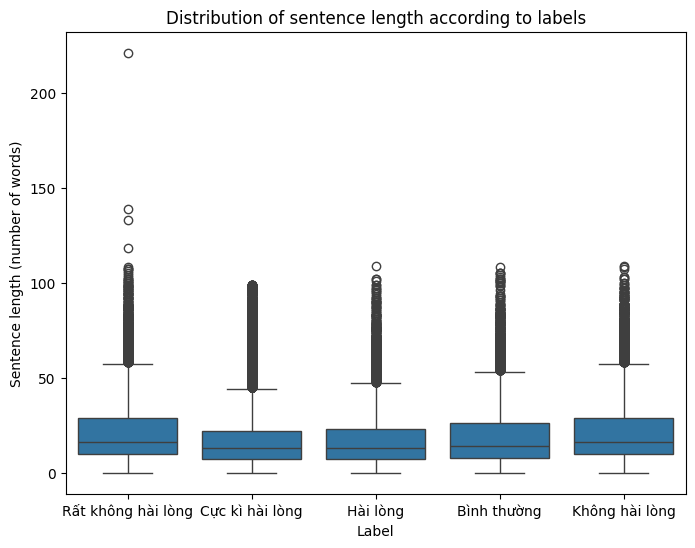

In [29]:
# Tính chiều dài câu
df_duplicated['length'] = df_duplicated['cleaned'].apply(lambda x: len(x.split()))

# Vẽ biểu đồ hộp (boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='title', y='length', data=df_duplicated)
plt.title('Distribution of sentence length according to labels')
plt.xlabel('Label')
plt.ylabel('Sentence length (number of words)')
plt.show()

In [30]:
# Tính các phần tư và IQR
Q1 = df_duplicated['length'].quantile(0.25)
Q3 = df_duplicated['length'].quantile(0.75)
IQR = Q3 - Q1

# Tính ngưỡng
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hiển thị ngưỡng
print(f"Ngưỡng dưới: {lower_bound}")
print(f"Ngưỡng trên: {upper_bound}")

# Tìm outliers
outliers = df_duplicated[(df_duplicated['length'] < lower_bound) | (df_duplicated['length'] > upper_bound)]

# Hiển thị kết quả
pd.set_option('display.width', 200)
print(f"Tổng số outliers: {len(outliers)}")
print("Outliers:")
print(outliers)

Ngưỡng dưới: -16.0
Ngưỡng trên: 48.0
Tổng số outliers: 5138
Outliers:
                                                  content               title                                            cleaned  length
13      điểm mẫu mã đẹp gọn nhẹ tốc độ truy xuất cao n...     Cực kì hài lòng  điểm mẫu mã đẹp gọn nhẹ tốc độ truy xuất cao n...      51
14      giao hàng nhanh trong ngày khi chọn vận chuyển...     Cực kì hài lòng  giao hàng nhanh trong ngày khi chọn vận chuyển...      52
18      sản phẩm giao nhanh đóng gói hơi sơ xài không ...     Cực kì hài lòng  sản phẩm giao nhanh đóng gói hơi sơ xài không ...      88
22      lần này thì đóng gói sản phẩm ổn hơn lần trước...     Cực kì hài lòng  lần này thì đóng gói sản phẩm ổn hơn lần trước...      51
55      Nếu bạn có thể sử dụng một vài bữa ăn, nó sẽ l...  Rất không hài lòng  nếu bạn có thể sử dụng một vài bữa ăn nó sẽ là...      55
...                                                   ...                 ...                               

In [31]:
df_duplicated[df_duplicated['length'] >= 100].shape

(49, 4)

In [32]:
df_duplicated = df_duplicated[df_duplicated['length'] < 100]

In [33]:
df_duplicated[df_duplicated['cleaned'].apply(lambda x: len(x.strip())) <= 1]

,content,title,cleaned,length
1678,ha ha,Cực kì hài lòng,,0
3574,fast,Cực kì hài lòng,,0
5798,qetulnbfwsdg,Cực kì hài lòng,,0
7326,hub,Cực kì hài lòng,,0
8046,TDF,Hài lòng,,0
...,...,...,...,...
100202,B NH,Không hài lòng,,0
102763,KJDKSJFKDJ,Bình thường,,0
102984,tmots,Cực kì hài lòng,,0
102996,hejdfndj,Cực kì hài lòng,,0


In [34]:
df_duplicated = df_duplicated[df_duplicated['cleaned'].apply(lambda x: len(x.strip())) > 1]
df_duplicated[df_duplicated['cleaned'].apply(lambda x: len(x.strip())) <= 1]

,content,title,cleaned,length


In [35]:
df_duplicated

,content,title,cleaned,length
0,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng,các sản phẩm lỗi mà quá trình trả lại rất khó ...,37
1,Các sản phẩm lỗi mà quá trình trả lại rất khó ...,Rất không hài lòng,các sản phẩm lỗi mà quá trình trả lại rất khó ...,40
2,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...,Cực kì hài lòng,hầu hết mọi thứ được chỉ là khi mở hàng tôi th...,43
3,ồ màn hình đẹp chân đế chắc chắn không có gì đ...,Cực kì hài lòng,ồ màn hình đẹp chân đế chắc chắn không có gì đ...,22
4,mọi thứ điều được nhưng do bên nhận vận chuyển...,Cực kì hài lòng,mọi thứ điều được nhưng do bên nhận vận chuyển...,18
...,...,...,...,...
106185,Trái ngược với công ty quảng cáo,Không hài lòng,trái ngược với công quảng cáo,6
106187,Sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...,Rất không hài lòng,sản phẩm được sử dụng sau nhiều tuần chỉ bị hỏ...,13
106188,Các sản phẩm được sử dụng sau nhiều tuần đã bị...,Rất không hài lòng,các sản phẩm được sử dụng sau nhiều tuần đã bị...,14
106189,Tiếng vang không ổn định,Rất không hài lòng,tiếng vang không ổn định,5


In [36]:
df_duplicated['title'].value_counts().reset_index()

,title,count
0,Cực kì hài lòng,48506
1,Rất không hài lòng,13406
2,Bình thường,12241
3,Không hài lòng,11152
4,Hài lòng,9433


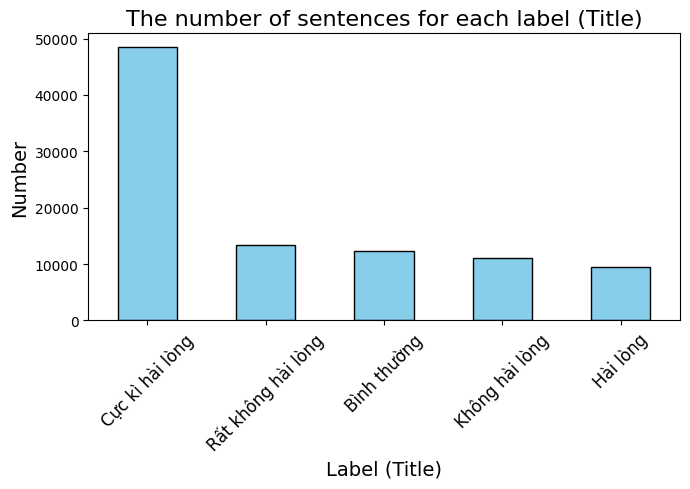

In [37]:
tag_counts = df_duplicated['title'].value_counts()
plt.figure(figsize=(7, 5))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('The number of sentences for each label (Title)', fontsize=16)
plt.xlabel('Label (Title)', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

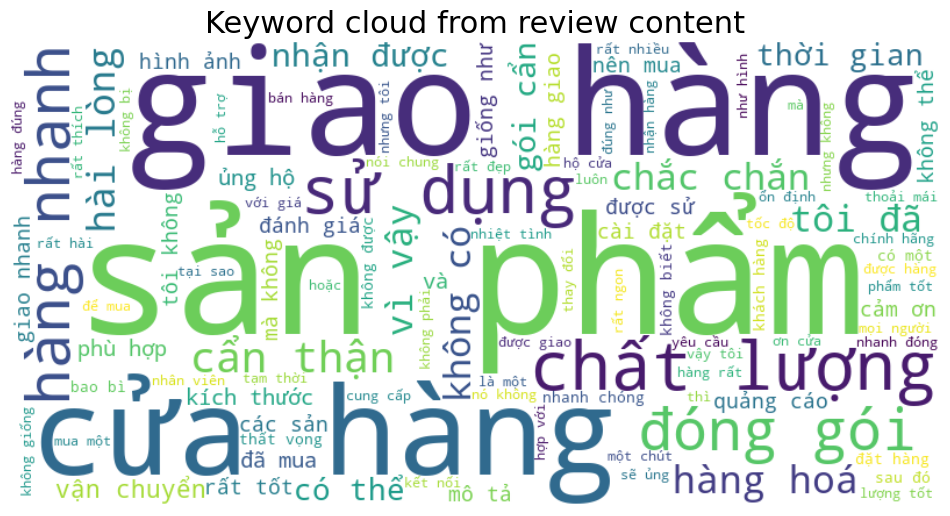

In [38]:
# Gộp toàn bộ nội dung trong cột 'content' thành một chuỗi
text = " ".join(df_duplicated['cleaned'])

# Tạo đám mây từ khóa
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(text)

# Hiển thị đám mây từ khóa
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword cloud from review content", fontsize=22)
plt.show()

In [39]:
word_counts = df_duplicated['length']

# Distribution of word counts
word_count_distribution = word_counts.value_counts().sort_index()
word_count_distribution.reset_index()

,length,count
0,1,337
1,2,1327
2,3,2351
3,4,3308
4,5,4153
...,...,...
94,95,25
95,96,20
96,97,23
97,98,18


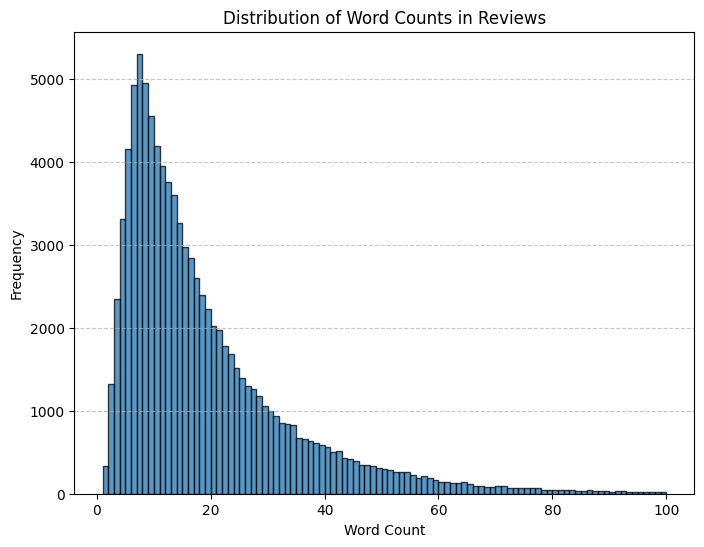

In [40]:
plt.figure(figsize=(8, 6))
plt.hist(word_counts, bins=range(1, max(word_counts) + 2), edgecolor='black', alpha=0.75)
plt.title("Distribution of Word Counts in Reviews")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# Thống kê số từ trong mỗi câu theo nhãn
word_count_stats = df_duplicated.groupby('title')['length'].describe()

# In ra thống kê phân phối độ dài câu theo từng nhãn
print(word_count_stats)
print()

# Đếm số lượng câu có độ dài từ 1 đến n từ cho mỗi nhãn
word_count_frequency = df_duplicated.groupby('title')['length'].value_counts().unstack(fill_value=0)

# In ra tần suất độ dài câu theo từng nhãn
print(word_count_frequency)


                      count  mean   std  min   25%   50%   75%   max
title                                                               
Bình thường        12241.00 19.42 15.32 1.00  8.00 14.00 26.00 99.00
Cực kì hài lòng    48506.00 16.68 13.83 1.00  7.00 13.00 22.00 99.00
Hài lòng            9433.00 17.49 14.89 1.00  7.00 13.00 23.00 99.00
Không hài lòng     11152.00 21.60 16.61 1.00 10.00 16.00 29.00 99.00
Rất không hài lòng 13406.00 21.65 16.57 1.00 10.00 16.00 29.00 99.00

length               1    2     3     4     5     6     7     8     9     10  ...  90  91  92  93  94  95  96  97  98  99
title                                                                         ...                                        
Bình thường          21   81   142   300   471   632   767   762   648   604  ...   1   2   2   4   1   0   1   0   2   1
Cực kì hài lòng     195  876  1678  2180  2459  2779  2792  2517  2344  2102  ...  13  16  13   5  11  15  12  12  11   9
Hài lòng             80  245

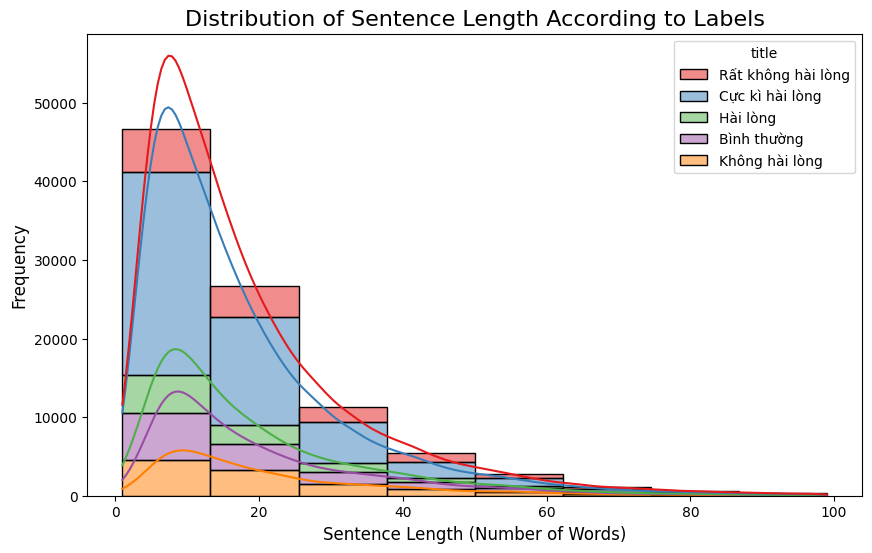

In [42]:
# Vẽ histogram với màu sắc dễ nhìn hơn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_duplicated, x='length', hue='title', kde=True, bins=8, palette='Set1', multiple="stack", edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Distribution of Sentence Length According to Labels', fontsize=16)
plt.xlabel('Sentence Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Hiển thị
plt.show()

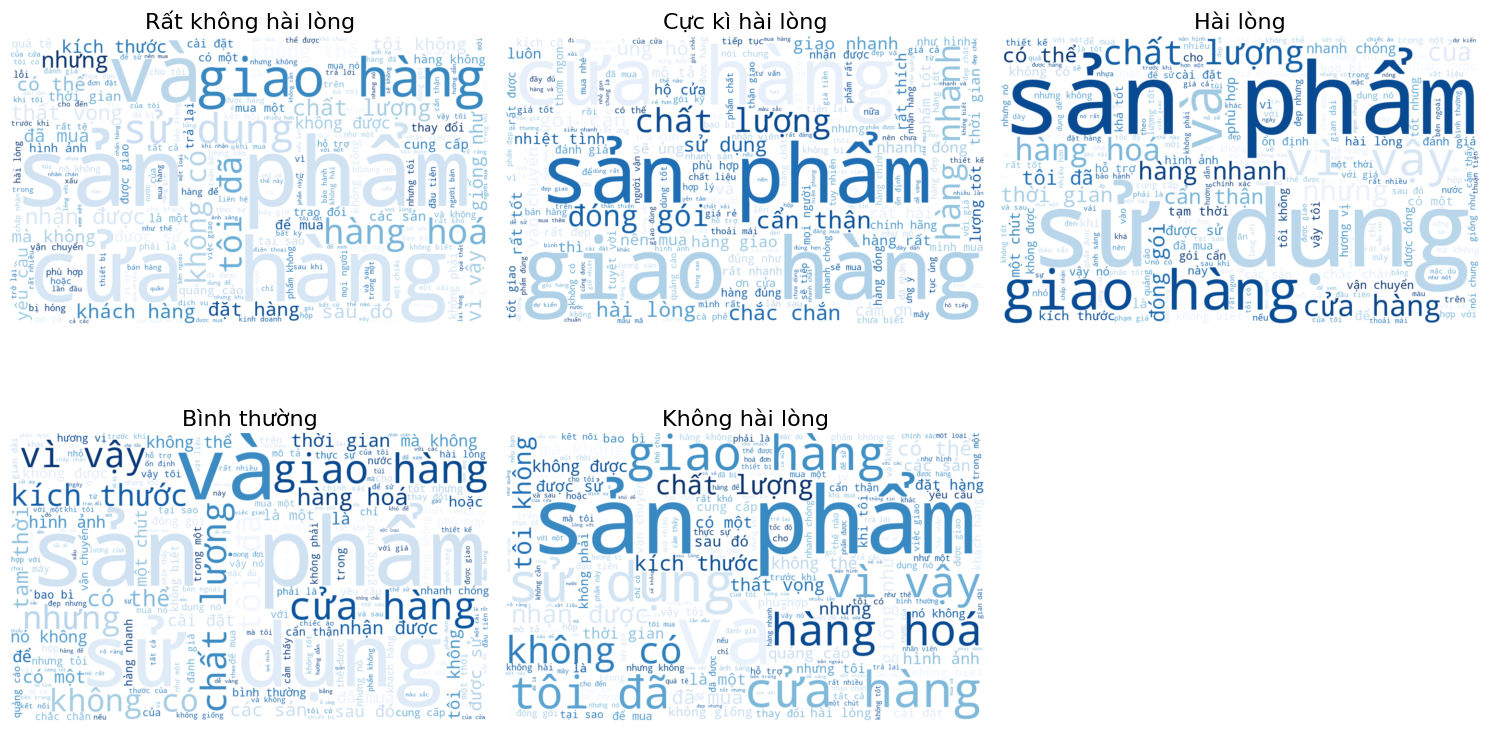

In [43]:
# Tạo word cloud cho từng nhãn
labels = df_duplicated['title'].unique()
plt.figure(figsize=(15, 20))

for idx, label in enumerate(labels):
    plt.subplot(5, 3, idx + 1)
    label_text = ' '.join(df_duplicated[df_duplicated['title'] == label]['cleaned'])

    # Tạo wordcloud cho nhãn này
    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='Blues').generate(label_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{label}', fontsize=16)

# Hiển thị các wordcloud
plt.tight_layout()
plt.show()

In [44]:
# Chọn lớp cần giảm ngẫu nhiên (ví dụ: 'Hài lòng')
label_to_reduce = 'Cực kì hài lòng'

# Tỷ lệ giảm (ví dụ: giảm 50% số lượng ví dụ của lớp 'Hài lòng')
reduction_ratio = 0.5

# Lọc dữ liệu của lớp cần giảm
df_label_to_reduce = df_duplicated[df_duplicated['title'] == label_to_reduce]

# Chọn ngẫu nhiên một tỷ lệ phần trăm của lớp này
df_label_reduced = df_label_to_reduce.sample(frac=reduction_ratio, random_state=42)

# Kết hợp lại với các lớp khác
df_reduced = pd.concat([df_duplicated[df_duplicated['title'] != label_to_reduce], df_label_reduced])

# In kết quả
print(df_reduced['title'].value_counts())

title
Cực kì hài lòng       24253
Rất không hài lòng    13406
Bình thường           12241
Không hài lòng        11152
Hài lòng               9433
Name: count, dtype: int64


In [45]:
label = ['Rất không hài lòng', 'Không hài lòng', 'Bình thường', 'Hài lòng', 'Cực kì hài lòng']
encoder = OrdinalEncoder(categories=[label])
y = encoder.fit_transform(df_duplicated["title"].values.reshape(-1, 1))

In [46]:
y

array([[0.],
       [0.],
       [4.],
       ...,
       [0.],
       [0.],
       [3.]], shape=(94738, 1))

In [47]:
X = df_duplicated['cleaned']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
pd.DataFrame(y_train).value_counts()

0   
4.00    38805
0.00    10725
2.00     9793
1.00     8921
3.00     7546
Name: count, dtype: int64

In [50]:
encoder.inverse_transform([[0]])

array([['Rất không hài lòng']], dtype=object)

In [51]:
# # Áp dụng SMOTE để xử lý mất cân bằng lớp
# # Cân bằng dữ liệu bằng SMOTE
# sampling_strategy = {
#     0: 12000,  # Lớp "Rất không hài lòng"
#     1: 4400,  # Lớp "Không hài lòng"
#     2: 8000,  # Lớp "Bình thường"
#     3: 16000,  # Lớp "Hài lòng"
# }

# smote = SMOTEN(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=10)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train.to_frame(), y_train)

In [52]:
# Vector hóa dữ liệu
tf_idf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=0.005,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [53]:
pd.DataFrame(y_train).value_counts()

0   
4.00    38805
0.00    10725
2.00     9793
1.00     8921
3.00     7546
Name: count, dtype: int64

In [54]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.ravel()
)

print(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

[1.41333333 1.69913687 1.54784029 2.00874636 0.39061977]


In [58]:
def objectiveLGBM(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        # "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 5,
        "class_weight": class_weights_dict,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000),
        "max_depth": trial.suggest_int("max_depth", 6, 20),
        "num_leaves": trial.suggest_int("num_leaves", 5, 30),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "n_jobs": -1,
    }
    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)

    lgbm_classifier.verbose = -1

    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train.ravel())

    # Evaluate the classifier on the test data
    y_pred = lgbm_classifier.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1



In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objectiveLGBM(trial, X_train_tf, y_train, X_test_tf, y_test), n_trials=100, n_jobs=-1)

In [60]:
best_params = study.best_params
print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.2873234741963746, 'n_estimators': 814, 'max_depth': 20, 'num_leaves': 29, 'subsample': 0.7769361952807919, 'colsample_bytree': 0.7536987550602086, 'min_child_samples': 6, 'lambda_l1': 0.013024286041060611, 'lambda_l2': 0.026253954465877364}


In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# model = LGBMClassifier(class_weight= class_weights_dict, verbose=-1)

# # Các tham số cần tối ưu
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [50, 100, 200]
# }

# # Sử dụng GridSearchCV
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=20,  # Số lượng tổ hợp tham số sẽ thử
#     scoring='f1',  # Thước đo để tối ưu hóa
#     cv=5,  # Số lần gấp cho cross-validation
#     verbose=1,  # In thông tin quá trình
#     random_state=42,  # Đảm bảo kết quả tái lập
#     n_jobs=-1  # Sử dụng tất cả các CPU
# )
# random_search.fit(X_train_tf, y_train)

# print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, an

Best parameters found:  {'num_leaves': 31, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}


                    precision    recall  f1-score   support

Rất không hài lòng       0.65      0.67      0.66      2448
    Không hài lòng       0.93      0.97      0.95      9701
       Bình thường       0.55      0.39      0.46      1887
          Hài lòng       0.75      0.70      0.72      2231
   Cực kì hài lòng       0.69      0.75      0.72      2681

          accuracy                           0.81     18948
         macro avg       0.71      0.70      0.70     18948
      weighted avg       0.80      0.81      0.80     18948



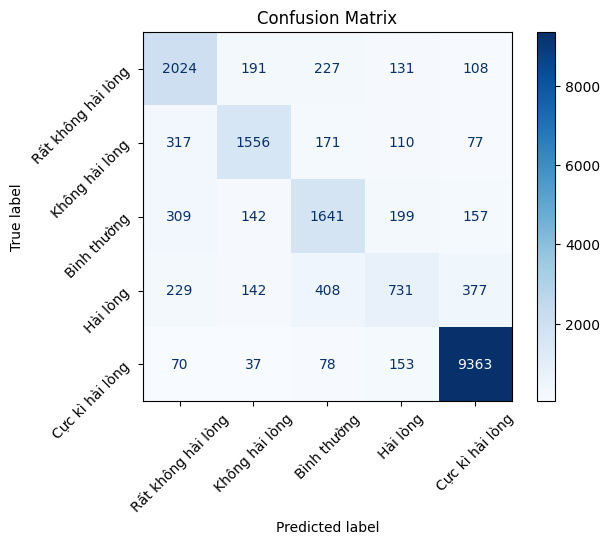

In [62]:
params = {'learning_rate': 0.2873234741963746, 'n_estimators': 814, 'max_depth': 20, 'num_leaves': 29, 'subsample': 0.7769361952807919, 'colsample_bytree': 0.7536987550602086, 'min_child_samples': 6, 'lambda_l1': 0.013024286041060611, 'lambda_l2': 0.026253954465877364}

model2 = LGBMClassifier(**params, n_jobs=-1, verbose=-1)
model2.fit(X_train_tf, y_train.ravel())

y_pred = model2.predict(X_test_tf)
y_pred_decoded = encoder.inverse_transform(y_pred.reshape(-1, 1))
print(classification_report(encoder.inverse_transform(y_test), y_pred_decoded, target_names=label))

# Lưu mô hình và vectorizer
joblib.dump(tf_idf, "tfidf_vectorizer.pkl")
joblib.dump(model2, "model2.pkl")

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

                    precision    recall  f1-score   support

Rất không hài lòng       0.63      0.67      0.65      2448
    Không hài lòng       0.95      0.94      0.94      9701
       Bình thường       0.49      0.46      0.47      1887
          Hài lòng       0.74      0.72      0.73      2231
   Cực kì hài lòng       0.69      0.74      0.71      2681

          accuracy                           0.80     18948
         macro avg       0.70      0.70      0.70     18948
      weighted avg       0.80      0.80      0.80     18948



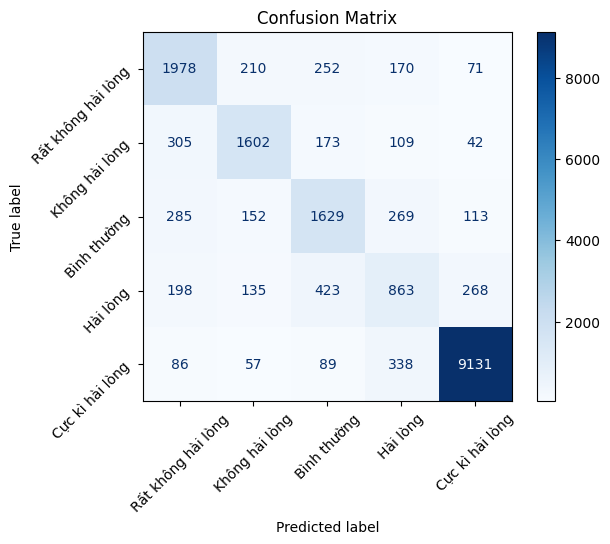

In [61]:
# params = {'learning_rate': 0.20314364688506467, 'n_estimators': 805, 'max_depth': 15, 'num_leaves': 30, 'subsample': 0.8365187554209608, 'colsample_bytree': 0.3359747200526028, 'min_child_samples': 28, 'lambda_l1': 0.01022850582344053, 'lambda_l2': 0.03628964178142716}
# params = {'learning_rate': 0.2620701584762431, 'n_estimators': 672, 'max_depth': 12, 'num_leaves': 24, 'subsample': 0.9759583546947141, 'colsample_bytree': 0.48415517357507065, 'min_child_samples': 14, 'lambda_l1': 0.009072909242242527, 'lambda_l2': 0.024903064318672317}
params = {'learning_rate': 0.2873234741963746, 'n_estimators': 814, 'max_depth': 20, 'num_leaves': 29, 'subsample': 0.7769361952807919, 'colsample_bytree': 0.7536987550602086, 'min_child_samples': 6, 'lambda_l1': 0.013024286041060611, 'lambda_l2': 0.026253954465877364}

model = LGBMClassifier(**params, class_weight=class_weights_dict, n_jobs=-1, verbose=-1)
model.fit(X_train_tf, y_train.ravel())

# model = RandomForestClassifier(random_state=2, n_estimators=100, min_samples_leaf=5, class_weight="balanced_subsample", n_jobs=-1)
# model.fit(X_train, y_train.ravel())
# Dự đoán và báo cáo kết quả
y_pred = model.predict(X_test_tf)
y_pred_decoded = encoder.inverse_transform(y_pred.reshape(-1, 1))
print(classification_report(encoder.inverse_transform(y_test), y_pred_decoded, target_names=label))

# Lưu mô hình và vectorizer
joblib.dump(tf_idf, "tfidf_vectorizer.pkl")
joblib.dump(model, "model.pkl")

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

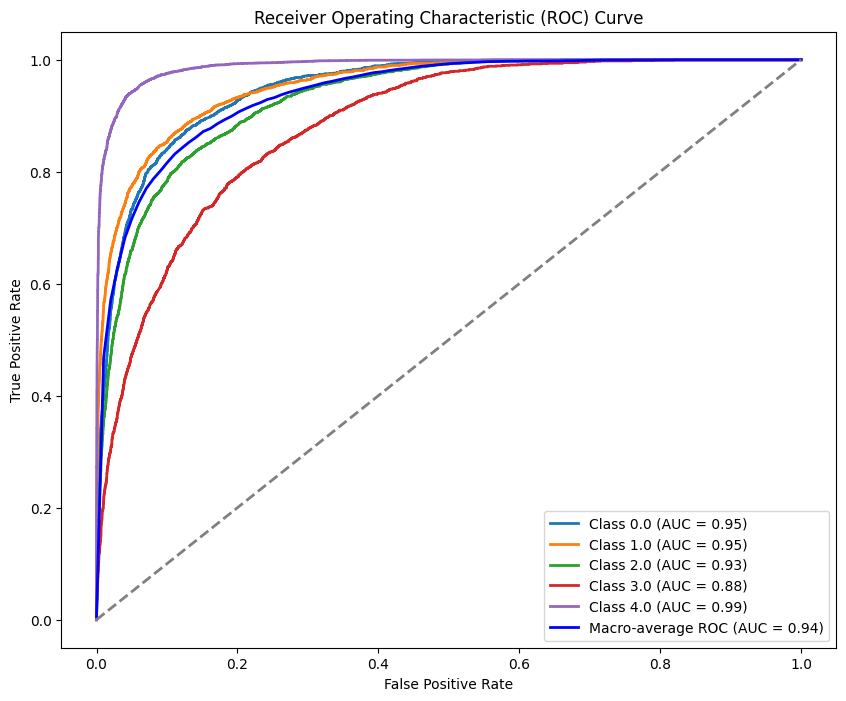

Macro AUC: 0.94


In [65]:
# Dự đoán xác suất cho tất cả các lớp
y_pred_prob = model2.predict_proba(X_test_tf)

# Biến y_test thành nhị phân cho bài toán đa lớp
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Số lớp trong bài toán
n_classes = y_test_binarized.shape[1]

# Khởi tạo các dictionary để lưu FPR, TPR và AUC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(10, 8))

# Tính FPR và TPR cho từng lớp và vẽ từng đường ROC
for i in range(n_classes):
    # Tính FPR và TPR cho từng lớp
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Vẽ ROC curve cho từng lớp
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Tính đường ROC trung bình (macro-average ROC curve)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

macro_auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')
# Vẽ đường ROC trung bình
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

# Vẽ đường ROC ngẫu nhiên (random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Thiết lập tiêu đề và nhãn cho đồ thị
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Tính AUC macro
print(f"Macro AUC: {macro_auc:.2f}")

In [66]:
def objectiveRF(trial):
    # Siêu tham số cần tối ưu
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }

    # Tạo mô hình RandomForestClassifier
    rf_model = RandomForestClassifier(**params)

    # Tính điểm CV (cross-validation) cho mô hình
    rf_model.fit(X_train_tf, y_train.ravel())

    # Evaluate the classifier on the test data
    y_pred = rf_model.predict(X_test_tf)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

In [67]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objectiveRF(trial), n_trials=100, n_jobs=-1)

[I 2025-01-15 22:56:43,759] A new study created in memory with name: no-name-de7db638-d7f1-4d36-ad3c-60b9d18828ec
[I 2025-01-15 22:56:46,958] Trial 11 finished with value: 0.3573255706371418 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 11 with value: 0.3573255706371418.
[I 2025-01-15 22:56:47,579] Trial 0 finished with value: 0.5428327168553848 and parameters: {'n_estimators': 58, 'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.5428327168553848.
[I 2025-01-15 22:56:48,553] Trial 10 finished with value: 0.5853121261350344 and parameters: {'n_estimators': 51, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 10 with value: 0.5853121261350344.
[I 2025-

In [68]:
best_params = study.best_params
print(f"Best Parameters: {best_params}")

Best Parameters: {'n_estimators': 144, 'criterion': 'entropy', 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}


In [72]:
rf_params = {'n_estimators': 144, 'criterion': 'entropy', 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_tf, y_train)
rf_y_pred = rf_model.predict(X_test_tf)
# joblib.dump(rf_model, "rf_model.pkl")

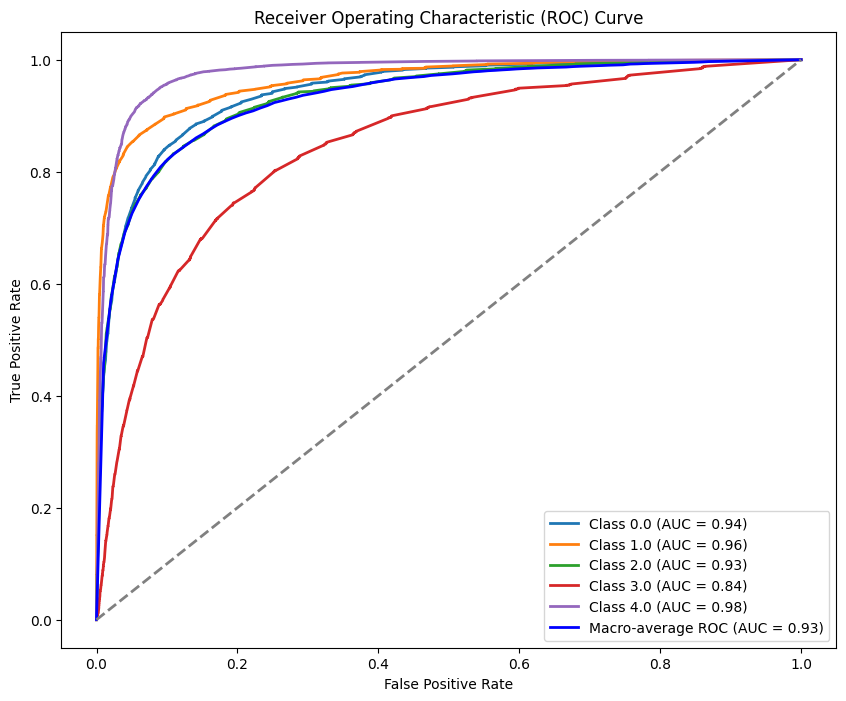

Macro AUC: 0.93


In [75]:
# Dự đoán xác suất cho tất cả các lớp
y_pred_prob = rf_model.predict_proba(X_test_tf)

# Biến y_test thành nhị phân cho bài toán đa lớp
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Số lớp trong bài toán
n_classes = y_test_binarized.shape[1]

# Khởi tạo các dictionary để lưu FPR, TPR và AUC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(10, 8))

# Tính FPR và TPR cho từng lớp và vẽ từng đường ROC
for i in range(n_classes):
    # Tính FPR và TPR cho từng lớp
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Vẽ ROC curve cho từng lớp
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Tính đường ROC trung bình (macro-average ROC curve)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

# Vẽ đường ROC trung bình
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

# Vẽ đường ROC ngẫu nhiên (random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Thiết lập tiêu đề và nhãn cho đồ thị
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Tính AUC macro
macro_auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro AUC: {macro_auc:.2f}")

In [74]:
y_pred_decoded = encoder.inverse_transform(rf_y_pred.reshape(-1, 1))
print(classification_report(encoder.inverse_transform(y_test), y_pred_decoded, target_names=label))

                    precision    recall  f1-score   support

Rất không hài lòng       0.69      0.68      0.69      2448
    Không hài lòng       0.88      0.97      0.93      9701
       Bình thường       0.60      0.24      0.35      1887
          Hài lòng       0.85      0.74      0.79      2231
   Cực kì hài lòng       0.68      0.79      0.73      2681

          accuracy                           0.81     18948
         macro avg       0.74      0.69      0.70     18948
      weighted avg       0.80      0.81      0.79     18948



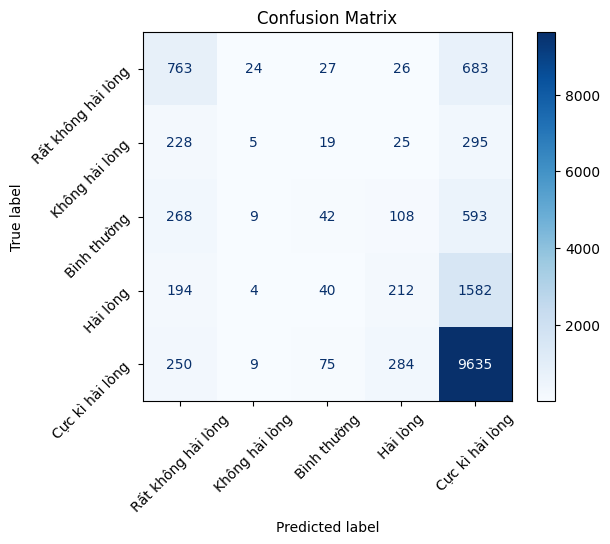

In [ ]:
cm = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [55]:
params = {'max_depth': 9, 'n_estimators': 760, 'gamma': 0.06653277496504952, 'reg_alpha': 0.9890868260154302, 'reg_lambda': 0.7161294659874443, 'learning_rate': 0.15043476200241776, 'subsample': 0.654993454681315, 'colsample_bytree': 0.6319093482018434, 'min_child_weight': 0}
xgb_model = XGBClassifier(class_weights=class_weights_dict, n_jobs=-1)

xgb_model.fit(X_train_tf, y_train.ravel())

xgb_y_pred = xgb_model.predict(X_test_tf)

y_pred_decoded = encoder.inverse_transform(xgb_y_pred.reshape(-1, 1))
print(classification_report(encoder.inverse_transform(y_test), y_pred_decoded, target_names=label))

joblib.dump(xgb_model, "xgb_model.pkl")

                    precision    recall  f1-score   support

Rất không hài lòng       0.50      0.43      0.46      2448
    Không hài lòng       0.85      0.98      0.91      9701
       Bình thường       0.54      0.28      0.37      1887
          Hài lòng       0.56      0.38      0.45      2231
   Cực kì hài lòng       0.54      0.66      0.59      2681

          accuracy                           0.72     18948
         macro avg       0.60      0.54      0.56     18948
      weighted avg       0.70      0.72      0.70     18948



['xgb_model.pkl']

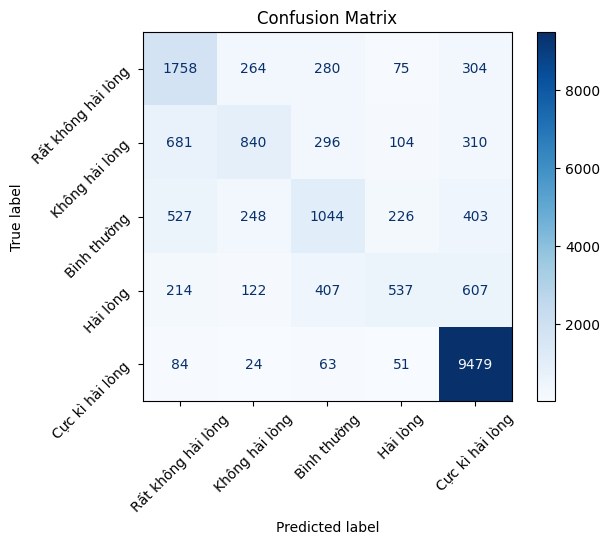

In [56]:
# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, xgb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

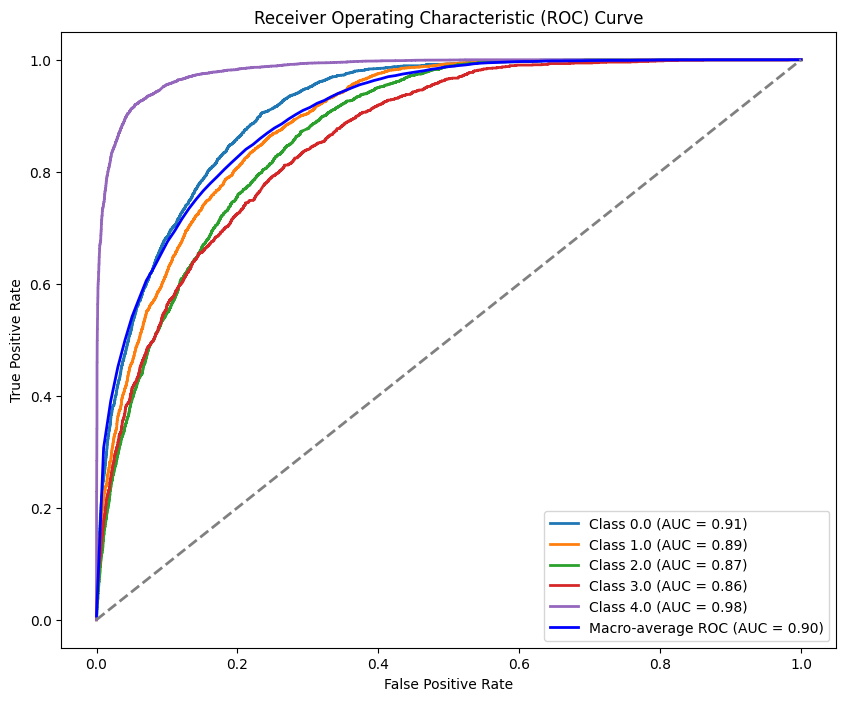

Macro AUC: 0.90


In [66]:
# Dự đoán xác suất cho tất cả các lớp
y_pred_prob = xgb_model.predict_proba(X_test_tf)

# Biến y_test thành nhị phân cho bài toán đa lớp
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Số lớp trong bài toán
n_classes = y_test_binarized.shape[1]

# Khởi tạo các dictionary để lưu FPR, TPR và AUC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(10, 8))

# Tính FPR và TPR cho từng lớp và vẽ từng đường ROC
for i in range(n_classes):
    # Tính FPR và TPR cho từng lớp
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Vẽ ROC curve cho từng lớp
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Tính đường ROC trung bình (macro-average ROC curve)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

macro_auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')
# Vẽ đường ROC trung bình
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

# Vẽ đường ROC ngẫu nhiên (random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Thiết lập tiêu đề và nhãn cho đồ thị
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Tính AUC macro
print(f"Macro AUC: {macro_auc:.2f}")

## Naive Bayes

In [77]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tf.toarray(), y_train)
nb_y_pred = nb_model.predict(X_test_tf.toarray())
nb_f1_score = f1_score(y_test, nb_y_pred, average='weighted')
joblib.dump(nb_model, "nb_model.pkl")

['nb_model.pkl']

In [78]:
y_pred_decoded = encoder.inverse_transform(nb_y_pred.reshape(-1, 1))
print(classification_report(encoder.inverse_transform(y_test), y_pred_decoded, target_names=label))

                    precision    recall  f1-score   support

Rất không hài lòng       0.39      0.35      0.37      2448
    Không hài lòng       0.82      0.98      0.89      9701
       Bình thường       0.55      0.18      0.27      1887
          Hài lòng       0.38      0.16      0.22      2231
   Cực kì hài lòng       0.47      0.63      0.54      2681

          accuracy                           0.67     18948
         macro avg       0.52      0.46      0.46     18948
      weighted avg       0.63      0.67      0.63     18948



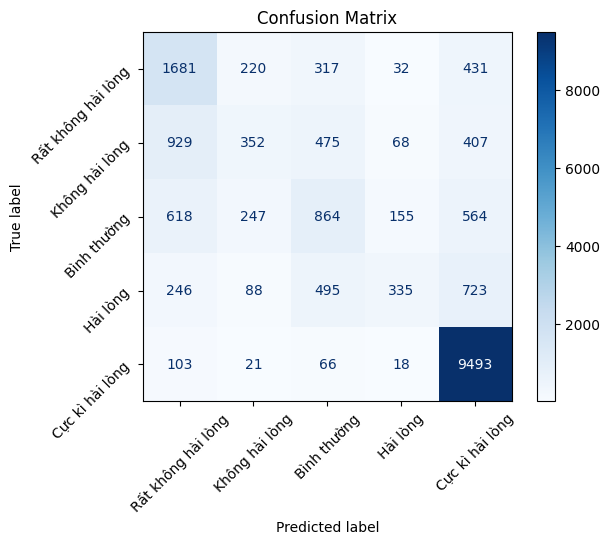

In [79]:
# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, nb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

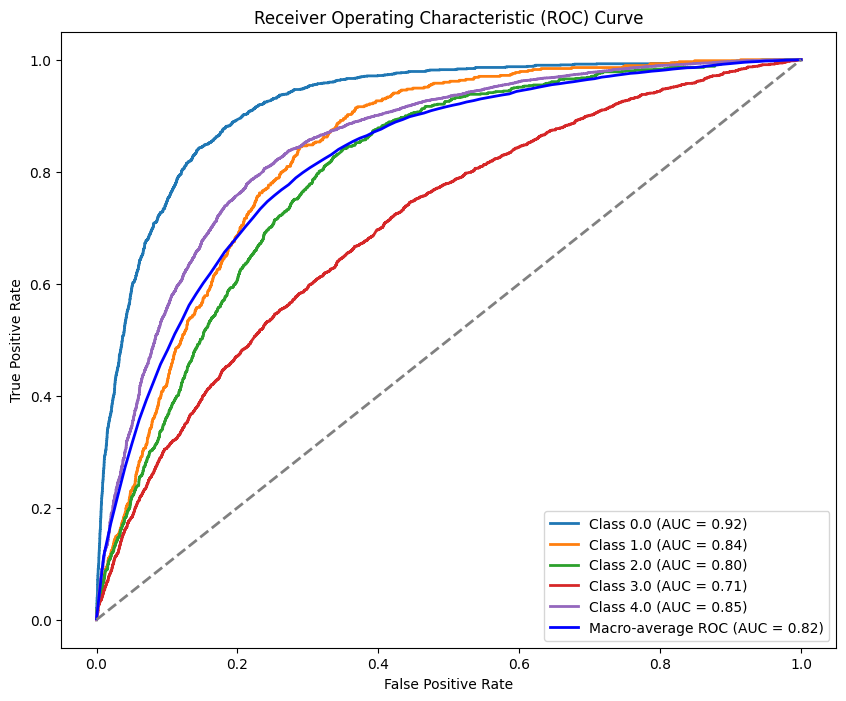

Macro AUC: 0.82


In [ ]:
# Dự đoán xác suất cho tất cả các lớp
y_pred_prob = nb_model.predict_proba(X_test_tf)

# Biến y_test thành nhị phân cho bài toán đa lớp
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Số lớp trong bài toán
n_classes = y_test_binarized.shape[1]

# Khởi tạo các dictionary để lưu FPR, TPR và AUC cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(10, 8))

# Tính FPR và TPR cho từng lớp và vẽ từng đường ROC
for i in range(n_classes):
    # Tính FPR và TPR cho từng lớp
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Vẽ ROC curve cho từng lớp
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Tính đường ROC trung bình (macro-average ROC curve)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

# Vẽ đường ROC trung bình
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

# Vẽ đường ROC ngẫu nhiên (random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Thiết lập tiêu đề và nhãn cho đồ thị
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Tính AUC macro
macro_auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro AUC: {macro_auc:.2f}")

In [ ]:
import joblib

# Tải bộ vector hóa TF-IDF và mô hình đã huấn luyện
tf_idf = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('model.pkl')

# Danh sách nhãn
label = ['Rất không hài lòng', 'Không hài lòng', 'Bình thường', 'Hài lòng', 'Cực kì hài lòng']

# Các văn bản thử nghiệm cho các trường hợp khác nhau
test_texts = [
    "Sản phẩm tệ",  # Lớp: 'Rất không hài lòng'
    "Sản phẩm kém chất lượng so với giá",  # Lớp: 'Không hài lòng'
    "Sản phẩm bình thường, không có gì đặc biệt",  # Lớp: 'Bình thường'
    "Sản phẩm cũng ổn",  # Lớp: 'Hài lòng'
    "Sản phẩm tuyệt vời, hoàn hảo, tôi cực kỳ hài lòng",  # Lớp: 'Cực kì hài lòng'
]

# Dự đoán cho từng văn bản
for text in test_texts:
    # Tiền xử lý văn bản
    cleaned_text = clean_text(text)

    # Chuyển đổi văn bản thành vector TF-IDF
    vectorized_text = tf_idf.transform([cleaned_text])

    # Dự đoán nhãn
    y_pred = model.predict(vectorized_text)

    # In ra kết quả
    print(f"Văn bản: {text}")
    print(f"Dự đoán nhãn: {label[int(y_pred[0])]}")  # Chuyển y_pred thành số nguyên để làm chỉ mục
    print("-" * 50)
